# EDA notebook

Expects the table `raw_power` to be created by ingester script `py/ingest_sqlite.py`.

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from py import sqlite_utils as utils

In [2]:
conn = utils.connect_sqlite()

### Number of rows, timestamp interval

In [3]:
utils.execute_sql_query("""
SELECT
    COUNT(*) AS n_rows,
    MIN(ts) AS min_time,
    MAX(ts) AS max_time
FROM raw_power;
""", conn=conn)

,n_rows,min_time,max_time
0,2075259,2006-12-16 17:24:00,2010-11-26 21:02:00


### Missing or duplicate timestamps (NULL timestamps were excluded by ingester script)

Validate that the timestamp column does not have duplicate values:

In [4]:
utils.execute_sql_query("""
SELECT
  COUNT(*) AS n_timestamps,
  COUNT(DISTINCT ts) AS n_distinct_timestamps,
  COUNT(*) - COUNT(DISTINCT ts) AS diff
FROM raw_power;
""", conn=conn)

,n_timestamps,n_distinct_timestamps,diff
0,2075259,2075259,0


Validate that the timestamp column does not have gaps, i.e. it is a full minute-grid:

In [5]:
utils.execute_sql_query("""
SELECT
  COUNT(*) as n_timestamps,
  (STRFTIME('%s', MAX(ts)) - STRFTIME('%s', MIN(ts))) / 60 + 1 as n_minutes_grid,
  COUNT(*) - ((STRFTIME('%s', MAX(ts)) - STRFTIME('%s', MIN(ts))) / 60 + 1) as diff
FROM raw_power;
""", conn=conn)

,n_timestamps,n_minutes_grid,diff
0,2075259,2075259,0


### Missing values - number of NULLs per row

Any row is either empty entirely, including target variable, or entirely full with all values non-NULL:

In [6]:
utils.execute_sql_query(
"""
SELECT 
    SUM(CASE WHEN n_present = 0 THEN 1 ELSE 0 END) AS fully_empty,
    SUM(CASE WHEN n_present BETWEEN 1 AND 6 THEN 1 ELSE 0 END) AS partially_empty,
    SUM(CASE WHEN n_present = 7 THEN 1 ELSE 0 END) AS fully_filled
FROM (
    SELECT
        (global_active_power IS NOT NULL) +
        (global_reactive_power IS NOT NULL) +
        (voltage IS NOT NULL) +
        (global_intensity IS NOT NULL) +
        (sub_1 IS NOT NULL) +
        (sub_2 IS NOT NULL) +
        (sub_3 IS NOT NULL) AS n_present
    FROM raw_power
) AS t;
""", conn=conn)

,fully_empty,partially_empty,fully_filled
0,25979,0,2049280


### Missing values - rate of empty rows per month

In [7]:
df_monthly_empty = utils.execute_sql_query("""
SELECT
    DATE(STRFTIME('%Y-%m-01 00:00:00', ts)) as month,
    1.0 * SUM(global_active_power IS NULL) / COUNT(*) empty_rate
FROM raw_power
GROUP BY month
ORDER BY month;
""", conn=conn)
df_monthly_empty['month'] = pd.to_datetime(df_monthly_empty['month']).dt.date

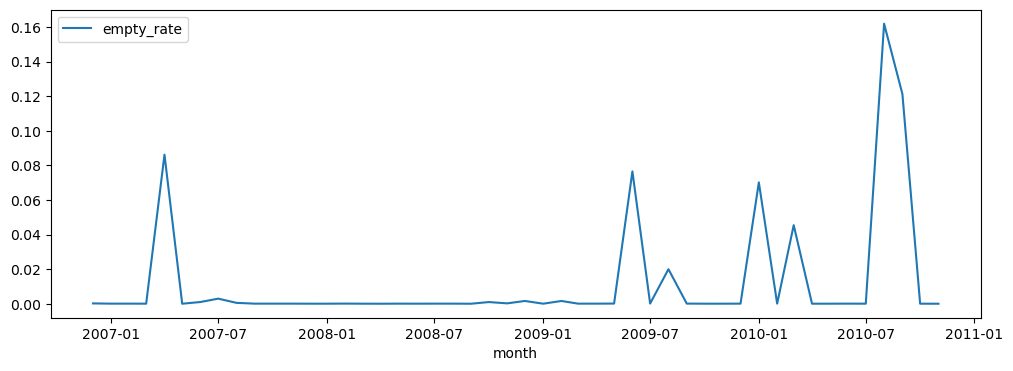

In [8]:
df_monthly_empty.plot(x='month', y='empty_rate', figsize=(12, 4))
plt.show()

### Missing values - rate of empty rows per day (heatmap)

In [9]:
df_daily_empty = utils.execute_sql_query("""
SELECT
    DATE(STRFTIME('%Y-%m-%d 00:00:00', ts)) as day,
    1.0 * SUM(global_active_power IS NULL) / COUNT(*) empty_rate
FROM raw_power
GROUP BY day
ORDER BY day;
""", conn=conn)

df_daily_empty['day'] = pd.to_datetime(df_daily_empty['day'])
df_daily_empty['month'] = df_daily_empty['day'].dt.to_period('M')
df_daily_empty['day'] = df_daily_empty['day'].dt.day

df_daily_empty_wide = df_daily_empty.set_index(['month', 'day'])['empty_rate'].unstack(level=0)

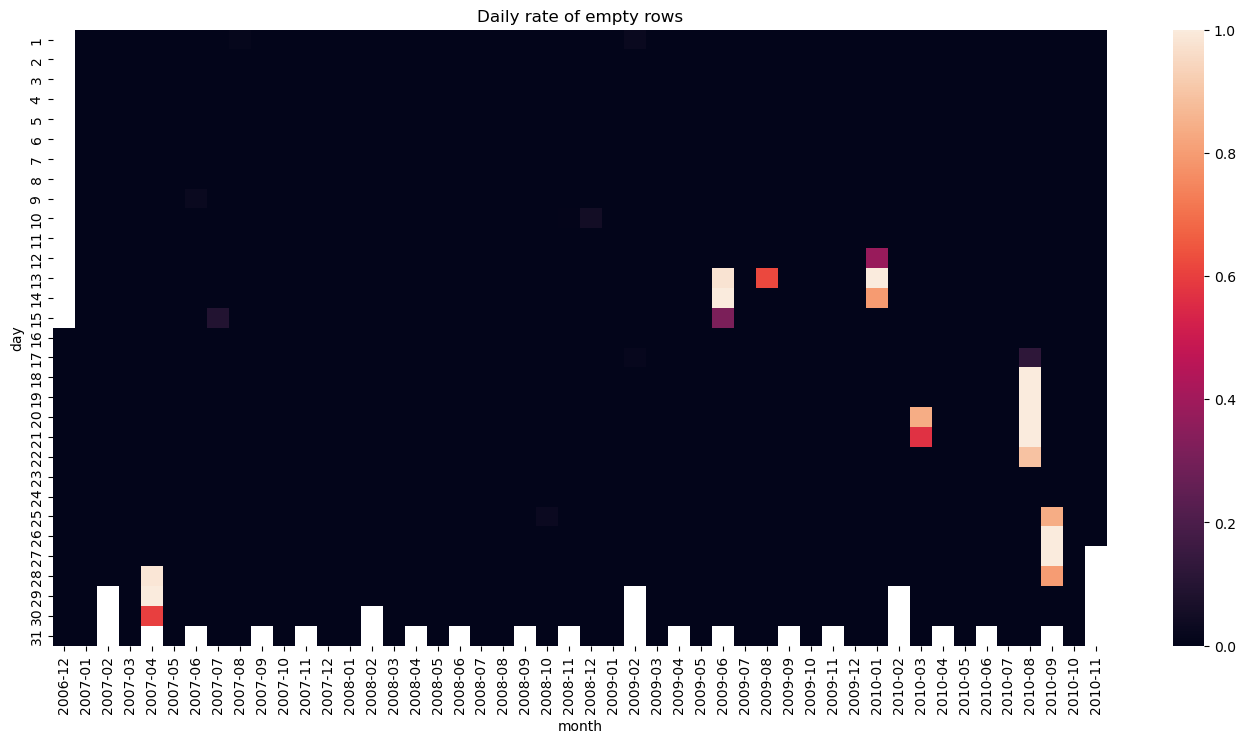

In [10]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.heatmap(df_daily_empty_wide, ax=ax)
plt.title('Daily rate of empty rows')
plt.show()

### Target variable distribution

In [11]:
target_df = utils.execute_sql_query("""
SELECT
    global_active_power
FROM raw_power
""", conn=conn)
target_df.describe().T

,count,mean,std,min,25%,50%,75%,max
global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122


In [12]:
target_df.isna().sum()

global_active_power    25979
dtype: int64

Target distribution is skewed heavily to the right judging by the relation between median, mean and max of target. Also important that target is always positive (or NULL).

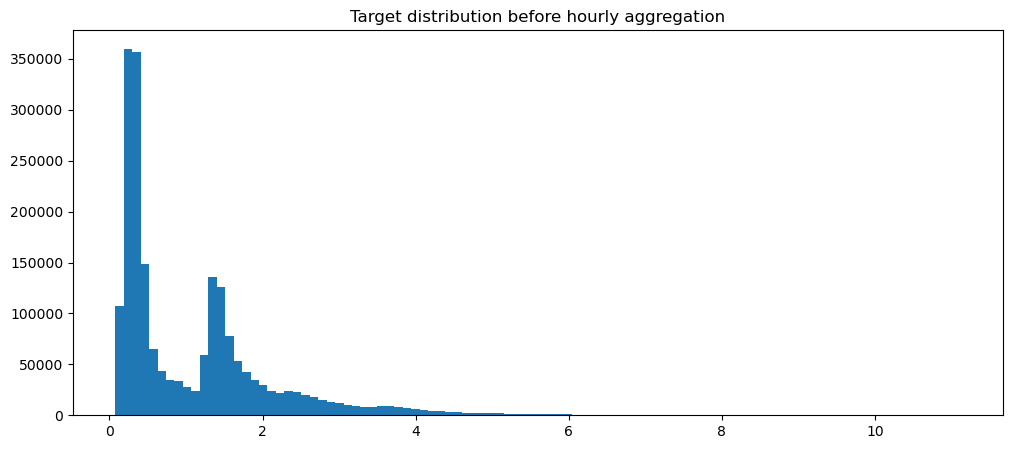

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.hist(target_df['global_active_power'], bins=100)
plt.title('Target distribution before hourly aggregation')
plt.show()

The target is exponentially distributed with two notable peaks, likely created by separate time-of-day clusters. Applying log to data makes it more suitable for model training.

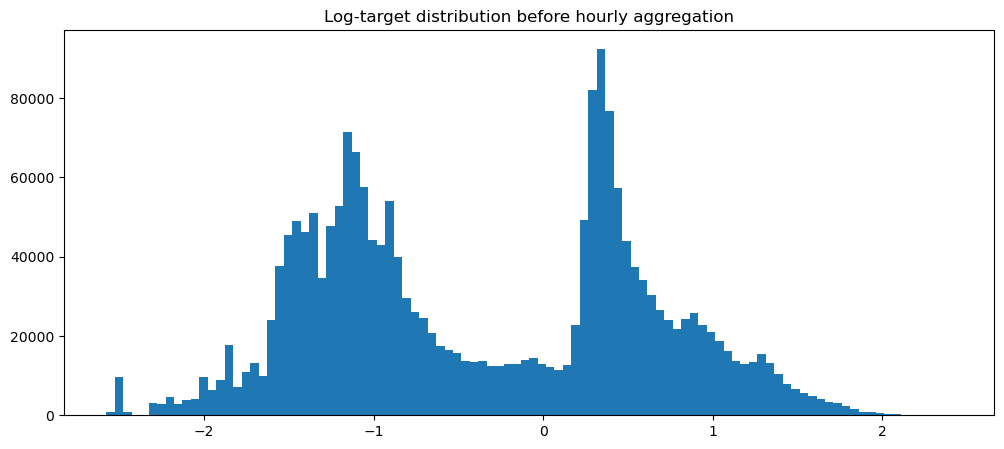

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.hist(np.log(target_df['global_active_power']), bins=100)
plt.title('Log-target distribution before hourly aggregation')
plt.show()

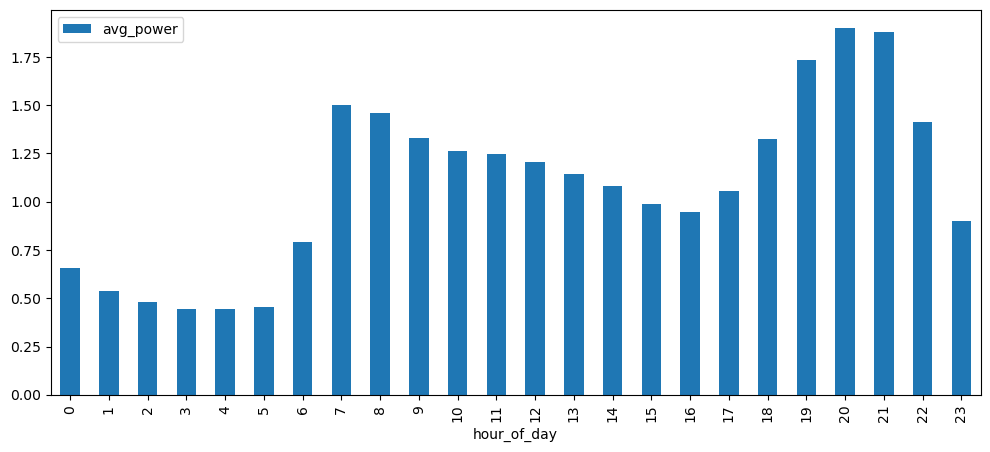

In [15]:
target_hourly_df = utils.execute_sql_query("""
SELECT CAST(strftime('%H', ts) AS INTEGER) AS hour_of_day, AVG(global_active_power) AS avg_power
FROM raw_power
GROUP BY hour_of_day
""", conn=conn)
target_hourly_df.plot(kind='bar', x='hour_of_day', y='avg_power', figsize=(12, 5))
plt.show()

Two peaks in target variable distribution correctly map to hourly average of target: the peaks represent nighttime and daytime power usage respectively.

In [16]:
conn.close()